#### This notebook explains the modeling and training process

### Table of content

** I. Import Neccessary libraries <br>
II. Import Dataset <br>
III. Data Cleansing and processing <br>
IV. Initializing the neural network <br>
V. Model Training **

--

## I. Import Neccessary Libraries

In [8]:
### If missing any library, please uncomment the repective line below and pip install
#!pip install tensorflow --upgrade
#!pip install h5py
#!pip install numpy --upgrade
#!pip install pandas
#!pip install dask --upgrade

## Taken from https://pypi.org/project/pygeohash/
## Using this instead of the python-geohash by hiwi due to better documentation

#!pip install pygeohash


In [9]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import pygeohash as pgh
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
import random
import math
import pickle
tqdm_notebook.pandas()
%matplotlib inline

## II. Import the Dataset

#### 1. Spilting the training dataset (sorely for github)
Had an issue where github do not allow commit above 100MB.<br>
My laptop had several issues in regarding the usage of github-lfs for large file<br>
Thus I spilt them up into two 80~ MB files, and combine them later in the code

In [10]:
## Load and spilt the dataframe
try:
    df = pd.read_csv("training.csv")
    df1 = df[:int(df.shape[0]/2)]
    df2 = df[int(df.shape[0]/2):]

## Save to csv
    df1.to_csv("training_1st_half.csv", index_label = False)
    df2.to_csv("training_2nd_half.csv", index_label = False)

## Already uploaded the sub dataset, this should go to the pass path all the time.
except:
    pass 

#### 2. Loading the dataset

In [18]:
df1 = pd.read_csv("training_1st_half.csv")
df2 = pd.read_csv("training_2nd_half.csv")
df = df1.append(df2, ignore_index = True)

An brief overview of the dataset

In [19]:
print("The dataset has " + str(df.shape[0]) + " rows and " + str(df.shape[1]) + " columns")  # 4,206,321 entries
print("A brief summary of numerical columns:")
print(df.describe())
print("First five rows of the dataset:")
print(df.head())

The dataset has 4206321 rows and 4 columns
A brief summary of numerical columns:
                day        demand
count  4.206321e+06  4.206321e+06
mean   3.145299e+01  1.050907e-01
std    1.768278e+01  1.592655e-01
min    1.000000e+00  3.092217e-09
25%    1.600000e+01  1.867379e-02
50%    3.200000e+01  5.043463e-02
75%    4.700000e+01  1.208644e-01
max    6.100000e+01  1.000000e+00
First five rows of the dataset:
  geohash6  day timestamp    demand
0   qp03wc   18      20:0  0.020072
1   qp03pn   10     14:30  0.024721
2   qp09sw    9      6:15  0.102821
3   qp0991   32       5:0  0.088755
4   qp090q   15       4:0  0.074468


## III. Data cleansing and processing

#### 1. Combine day and timestamp columns to time_stamp column
This column measure the index of timestamp from day 1 first time stamp (0) to day 61 last timestamp (5855)

In [20]:
def string_to_time (string):
    x = string.split(":")
    timing = int(x[0]) * 60 + int(x[1])
    return timing/15

df['time_stamp'] = df['timestamp'].progress_apply(string_to_time)
df['time_stamp'] = df['time_stamp'] + (df['day'] - 1)*96
df.head()

A Jupyter Widget

,geohash6,day,timestamp,demand,time_stamp
0,qp03wc,18,20:0,0.020072,1712.0
1,qp03pn,10,14:30,0.024721,922.0
2,qp09sw,9,6:15,0.102821,793.0
3,qp0991,32,5:0,0.088755,2996.0
4,qp090q,15,4:0,0.074468,1360.0


In [21]:
df.describe()   ##Time stamp from 0 to 5855 (5856 = 61 x24 x 4)

,day,demand,time_stamp
count,4.206321e+06,4.206321e+06,4.206321e+06
mean,3.145299e+01,1.050907e-01,2.964249e+03
std,1.768278e+01,1.592655e-01,1.697748e+03
min,1.000000e+00,3.092217e-09,0.000000e+00
25%,1.600000e+01,1.867379e-02,1.477000e+03
50%,3.200000e+01,5.043463e-02,3.010000e+03
75%,4.700000e+01,1.208644e-01,4.428000e+03
max,6.100000e+01,1.000000e+00,5.855000e+03


#### 2. Identify unique geohash6-s
A total of 1329 unique geohash markers

In [22]:
de = df.groupby(['geohash6']).count()
hash_list = de.index.values
hash_list = np.squeeze(hash_list)
print(len(hash_list))
hash_list

1329


array(['qp02yc', 'qp02yf', 'qp02yu', ..., 'qp0dnh', 'qp0dnj', 'qp0dnn'],
      dtype=object)

#### 3. Pivot the original 4206321 by 4 dataframe to time_stamp vs geohash6 (5847 by 1329)
There's 5856 time stamps<br>
The dataframe is then filled with 0 to replace NaN to prevent any numerical calculation errors

In [23]:
# Pivot
df = pd.pivot_table(df, values='demand', index=['time_stamp'],columns=['geohash6'])

# Fill all NaN as numeric 0
df = df.fillna(0)

## Fill up any missing time_stamp
df = df.reindex(range(int(df.index.values[-1])+1), fill_value=0)

print(df.shape)
df.head()

(5856, 1329)


geohash6,qp02yc,qp02yf,qp02yu,qp02yv,qp02yy,qp02yz,qp02z1,qp02z3,qp02z4,qp02z5,...,qp0djv,qp0djw,qp0djy,qp0dn0,qp0dn1,qp0dn4,qp0dn5,qp0dnh,qp0dnj,qp0dnn
time_stamp,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0006,...,0.0,0.0,0.004056,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.009381,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.0,0.008253,0.0,0.0,0.0,0.0,0.0,0.002701,0.0


#### 4. Converting the time_stamp vs geohash6 table to a list of historical data for each demand entry to be the input of model
This is the most difficult part of the data processing section.<br><br>
I would like to sample past 13 days record for each entry, if applicable( to be safe from exceeding limit of up to 14days, also to reduce dataframe size to a small extent)<br>
However this will add additonal 13 x 24 x 4 -1 = 1247 columns to the existing dataset, rendering it impossible to be handled on local server due to memory issues in processing a ~ 4millon by 1250 dataframe. (roughly 180 GB of RAM for such df)<br><br>
To tackle this, I adopt the minibatch technique and use a random sampling method to sample 20 geohash using a rolling window technique on the training dataset.<br> This provides me with roughly 50,000 entries for each sampling frame as training set. <br><br>
By keeping the parameters from previous learning cycles and resampling training set, this repeated process will achieve an approximate accuracy of training on the entire dataset (minibatch idea)<br>
The development set is not resampled, as it is a very small.<br><br>
**Training and Development set format**:<br>
**Features consisting of**:<br>
1248 columns of demand from timestamp = T-1248 to timestamp = T-1<br>
1 column of the demand at timestamp = T<br>
2 columns of geohash6 data in terms of latitude and longitude. This is decoded using pygeohash library <br>
**Targets being**:<br>
5 columns the demand at timestamp = T+1 to timestamp = T+5 <br>
**This makes a total of 1251 features and 5 targets **

In [24]:
def resampling(df,seed = 10):
    '''
    This function takes in 3 arguments: a training dataframe, a limit (int) and a seed (int) for randomization
    
    This function randomly pick 30 geohash6 from the list of available geohash6 in the training dataframe based on the seed
    It then perform a rolling window of 1248 + 1 + 5 = 1254 width on the dataframe's subset of only the selected geohash6-s
    It then append the result of the rolling window as well as the decoded geohash to the X and Y dataframe respectively
    It repeats until all 20 geohash6 are completed, other than the last entry where less than 20 is possible.
    
    This function returns the training X and Y of the randomed sample
    '''
    # Create placeholder for the data
    X = pd.DataFrame({"index":list(np.core.defchararray.add("T-",np.arange(1248,0,-1).astype("str")))+\
                           ["T","lat","lon"]})
    Y = pd.DataFrame({"index":["T+1","T+2","T+3","T+4","T+5"]})
    
    # Find all geohash in the dataframe and return a list
    hash_list = df.T.index.values
    
    # Set up seed for randomization, if needed
    random.seed(seed)
    
    # Try to generate 20 geohash if the total geohash > 20
    try:
        sample = random.sample(range(0, len(hash_list)), 20)
    except:
        sample = range(len(hash_list))
        
    # Keep track of number of rows (k) and sampled geohash (sampled_list)
    k=0
    sampled_list = []
    
    
    for geohash in tqdm_notebook(hash_list[sample]):
        
        # Decode geohash
        lat = pgh.decode(geohash)[0]
        lon = pgh.decode(geohash)[1]
        
        for i in range(1248,df.shape[0]-5):
            
            ''' 
            This is a rolling window across the entire dataframe column wise (per geocode)
            This samples 1248 entries prior of a non-zero value as well as 5 values after 
            '''
            if df[geohash].values[i] > 0:
                k+=1
                X[str(k)] = list(df[geohash].values[i-1248:i+1])+[lat,lon]
                Y[str(k)] = list(df[geohash].values[i+1:i+6])
                
        sampled_list += [geohash]
        
    print(len(sampled_list),"Geohash-s sampled,",len(hash_list)-len(sampled_list)," remaining")

    # Transpose the change into dtype float
    X=np.array(X.T.drop(['index'])).astype("float")
    Y=np.array(Y.T.drop(['index'])).astype("float")
    
    print("This sample has:",k,"rows")
    
    return X,Y ,sampled_list

In [25]:
def dev_sampling(df):
    '''
    This function is similar to resampling()
    This function takes in 1 argument: a dataframe
     
    This function performs a rolling window of 1248 + 1 + 5 = 1254 width on the dataframe
    It then append the result of the rolling window as well as the decoded geohash to the X and Y dataframe respectively
    It repeats until it loops through the entire dataframe
    
    This function returns the dev X and Y of the randomed sample
    '''
    X = pd.DataFrame({"index":list(np.core.defchararray.add("T-",np.arange(1248,0,-1).astype("str")))+\
                           ["T","lat","lon"]})
    Y = pd.DataFrame({"index":["T+1","T+2","T+3","T+4","T+5"]})

    k=0
    print("Converting to each row to record 13 days prior data as well as from T to T+5, latitude and longitude\nThis will take a while")
    for geohash in tqdm_notebook(hash_list):
        for i in range(1248,df.shape[0]-5):
            if df[geohash].values[i] > 0:
                try:
                    k+=1
                    X[str(k)] = list(df[geohash].values[i-1248:i+1])+[pgh.decode(geohash)[0],pgh.decode(geohash)[1]]
                except:
                    k+=1
                    print(df[geohash].values[i])
                    print(list(df[geohash].values[i-1248:i+6])+[geohash])
                    
                # If no target is provided, return a array of five zero (used for prediction of use case)
                try:
                    Y[str(k)] = list(df[geohash].values[i+1:i+6])
                except:
                    Y[str(k)] = [0,0,0,0,0]

    X=np.array(X.T.drop(['index'])).astype("float")
    Y=np.array(Y.T.drop(['index'])).astype("float")   
    print("This sample has:",k,"rows")
    
    return X,Y

#### 5. Train/Dev Split
**I used a train testt split of 99% training and 1% testing.<br>
This gives me 14 geohashs of data in the developement set **

In [26]:
train,dev = train_test_split(df.T, test_size=0.01, random_state=42)

**A mock sampling of training set** (used to debug the initiation of neural network)

In [27]:
# train_X_0, train_Y_0,_ = resampling(train.T,99)
# print("Training set have the shape of:",(train_X_0.shape,train_Y_0.shape))

**Sampling of the development set** <br>
Loading from existing set (seed = 42), if possible

In [28]:
try:
    # Try to load exisiting pickled file, (file not uploaded to github due to large size)
    dev_X,dev_Y = pickle.load(open("dev.pkl",'rb'))
    open("dev.pkl",'rb').close()
    print("Loaded Development set have the shape of:",(dev_X.shape,dev_Y.shape))
except:
    dev_X,dev_Y = dev_sampling(dev.T)
    print("Reloaded Development set have the shape of:",(dev_X.shape,dev_Y.shape))
    filehandler = open("dev.pkl","wb")
    pickle.dump((dev_X,dev_Y),filehandler)
    filehandler.close()

Loaded Development set have the shape of: ((40698, 1251), (40698, 5))


## IV. Initializing the Neural Network Model

### 1. Preparation

**A 3 layers neural network with tensorflow framework was used for this challenge.**<br>
<br>
The layers are of following:<br>
L-0: Input layer of 1251 features <br>
L-1: A hidden layer of 250 features <br>
L-2: A hidden layer of 50 features <br>
L-3: A predicting layer of 5 features<br><br>
<br>
The pipline is Linear - Relu - Linear - Relu - Linear <br>
Cost is measured by mean square error, same as required in the challenge<br>
<br>
Due to memory issue mentioned above, I train each sub training sample set for 30 epoches before resampling.<br>
This is repeated for all 66 sub training sample set in the training set.

__*I would like to thank and credit deeplearning.ai for providing me with a basic template for Neural Network and a few useful functions via their courses. *__

In [29]:
def create_placeholders(n_x,n_y):
    '''
    This function creates Tensorflow placeholders of correct dimensions
    '''
    X = tf.placeholder(tf.float32, [None,n_x], name="X")
    Y = tf.placeholder(tf.float32, [None,n_y], name="Y")
    
    return X, Y

In [30]:
## For Testing and Debugging
X, Y = create_placeholders(120, 5)
print("X = " + str(X))
print("Y = " + str(Y))

X = Tensor("X:0", shape=(?, 120), dtype=float32)
Y = Tensor("Y:0", shape=(?, 5), dtype=float32)


In [31]:
def initialize_parameters(n_x,n_y,parameters = None):
    '''
    This function initialized the 3 layers neural network with the correct dimensions.
    Randoming the variables in the first time
    Assigning the past parameter if given --> allowing transfer learning
    '''
    
    if parameters != None:
        
        W1 = tf.get_variable("W1", initializer = parameters['W1'])
        b1 = tf.get_variable("b1", initializer = parameters['b1'])
        W2 = tf.get_variable("W2", initializer = parameters['W2'])
        b2 = tf.get_variable("b2", initializer = parameters['b2'])
        W3 = tf.get_variable("W3", initializer = parameters['W3'])
        b3 = tf.get_variable("b3", initializer = parameters['b3'])
        print("Past parameters updated")
    
    else:
        W1 = tf.get_variable("W1", [n_x, 250], initializer = tf.contrib.layers.xavier_initializer())
        b1 = tf.get_variable("b1", [1],initializer = tf.zeros_initializer())
        W2 = tf.get_variable("W2", [250, 50], initializer = tf.contrib.layers.xavier_initializer())
        b2 = tf.get_variable("b2", [1], initializer = tf.zeros_initializer())
        W3 = tf.get_variable("W3", [50, n_y], initializer = tf.contrib.layers.xavier_initializer())
        b3 = tf.get_variable("b3", [1], initializer = tf.zeros_initializer())
        
    param = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    return param

In [32]:
## For Testing and Debugging 
tf.reset_default_graph()
with tf.Session() as sess:
    test_parameters = initialize_parameters(1251,5)
    print("W1 = " + str(test_parameters["W1"]))
    print("b1 = " + str(test_parameters["b1"]))
    print("W2 = " + str(test_parameters["W2"]))
    print("b2 = " + str(test_parameters["b2"]))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
W1 = <tf.Variable 'W1:0' shape=(1251, 250) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(1,) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(250, 50) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(1,) dtype=float32_ref>


In [33]:
def forward_propagation(X, parameters):
    '''
    This function obtain coefficient of various parameters and use them to predict a final cost(Z3)
    This process consists of  a linear function of X @ W1 + b1, @ being matrix multiplication,
        followed by a retilinear activation function 
    '''
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    #print(X)
    Z1 = tf.add(tf.matmul(X,W1), b1)                      
    A1 = tf.nn.relu(Z1)  
    Z2 = tf.add(tf.matmul(A1,W2), b2)     
    A2 = tf.nn.relu(Z2)    
    Z3 = tf.add(tf.matmul(A2,W3), b3)  

    return Z3

In [34]:
## For Testing and Debugging 
tf.reset_default_graph()
with tf.Session() as sess:
    X, Y = create_placeholders(1251, 5)
    parameters = initialize_parameters(1251,5)
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(?, 5), dtype=float32)


In [35]:
def compute_cost(Z3, Y,parameters):
    '''
    This function compute the mean square error bewteen the 5 entries in predicted Z3 and the 5 entries in actual Y
    '''
    #print(Z3,Y)
    m = Y.shape[1] 
    W1 = parameters["W1"]
    W2 = parameters["W2"]    
    W3 = parameters["W3"]
    
    rmse_cost = tf.reduce_mean(tf.losses.mean_squared_error(predictions=Z3, labels=Y))
    
    # Loss function using L2 Regularization
    regularizer = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3)

    
    # add cross_entropy_cost and L2_regularization_cost
    cost = tf.reduce_mean(rmse_cost + 0.01 * regularizer)
    
    return cost

In [36]:
## For Testing and Debugging 
tf.reset_default_graph()
with tf.Session() as sess:
    X, Y = create_placeholders(1251, 5)
    parameters = initialize_parameters(1251,5)
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y,parameters)
    print("cost = " + str(cost))

Instructions for updating:
Use tf.cast instead.
cost = Tensor("Mean_1:0", shape=(), dtype=float32)


**The below function **random_mini_batches() **is obtained from deeplearning.ai on 9th June 2019. unedited**<br>
It is used to create random mini batches by shuffling.

In [37]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[ permutation,:]
    shuffled_Y = Y[permutation,:].reshape(m,(Y.shape[1]))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch_Y = shuffled_Y[ k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[ num_complete_minibatches * mini_batch_size : m,:]
        mini_batch_Y = shuffled_Y[ num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### 2. Model Training and Transfer Learning
The below function initiates the tensorflow session and provide the possibility for transfer learning on previously trained parameters

In [38]:
def model(train,dev_X,dev_Y,iterations = 10,learning_rate = 0.0001, k = 0,
          num_epochs = 30, batch_size = 64, print_cost = True,parameters = None,train_acc =None, dev_acc = None):
    '''
    Initiate the Tensorflow session and combine all previous functions.
    Using an AdamOptizer to minimise the mean square error of the prediction
    Allow transfer learning using previous parameters
    return trained parameter, train and dev acc for plotting
    '''
    ops.reset_default_graph()
    
    r = 1
    tf.set_random_seed(r)
    seed = random.randint(1,1000)
    
    #Initial sampling of training data
    # Try to load exisiting data (fast, ~5sec), else resample from train dataset (slow ~ 10min)
    try:
        train_X,train_Y,sample_list = pickle.load(open("./temp_training_set/train"+str(k)+".pkl",'rb'))
        open("./temp_training_set/train"+str(k)+".pkl",'rb').close()
        print("loaded exising dataset")
    except:
        print("Resampling new dataset")
        train_X, train_Y, sample_list = resampling(train)  
        filehandler = open("./temp_training_set/train"+str(k)+".pkl","wb")
        pickle.dump((train_X,train_Y,sample_list),filehandler)
        filehandler.close()
        
    (m,n_x) = train_X.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = train_Y.shape[1]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    if dev_acc == None:
        dev_acc = []                                          # To keep track of dev accuracy
    if train_acc == None:
        train_acc = []                                     # To keep track of train accuracy
    
    ## Setting various pipeline functions
    X, Y = create_placeholders(n_x, n_y)              #Create placeholder

    param = initialize_parameters(n_x,n_y,parameters)     #Randomise the first set of parameters with the correct dimension

    Z3 = forward_propagation(X, param)           #Calculate Z3 using lin-relu-lin-relu-lin
    
    cost = compute_cost(Z3, Y,param)                        #Compute the cost of this iteration
   
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Use an Adam Optimatizer for the cost
    
    init = tf.global_variables_initializer()        

    #Start the tensorflow Session
    with tf.Session() as sess:

        sess.run(init)
        
        # Looping for each resampling session
        for i in range(iterations):
            print("Iteration",k)
            k += 1
            for epoch in tqdm_notebook(range(num_epochs)):

                epoch_cost = 0.                       # Defines a cost related to an epoch
                num_minibatches = int(m / batch_size)

                seed = seed + 1
                minibatches = random_mini_batches(train_X,train_Y, batch_size, seed)
                
                
                # looping through minibatches
                for minibatch in minibatches:

                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch

                    _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

                    epoch_cost += minibatch_cost / num_minibatches


                # Print the cost every 10 epoches in the resampling frame
                if print_cost == True and epoch % 10 == 0:
                    print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                if print_cost == True and epoch % 5 == 0:
                    costs.append(epoch_cost)
                    
            
            # Caculate the error            
            rmse = tf.reduce_mean(tf.losses.mean_squared_error(predictions=Z3, labels=Y))
            dev_acc.append(rmse.eval({X:dev_X, Y: dev_Y}))
            train_acc.append(rmse.eval({X:train_X, Y: train_Y}))
            print("Training error: {:.6f}".format(rmse.eval({X:train_X, Y: train_Y})))
            print("Validation error: {:.6f}".format(rmse.eval({X:dev_X, Y: dev_Y})))
            
            
            #Drop the trained column and resample the training set after finishing the last epoch
            train = train.drop(sample_list,axis=1)  
            
            if i < iterations-1:
                # Try to load exisiting data (fast, ~5sec), else resample from train dataset (slow ~ 10min)
                try:
                    train_X,train_Y,sample_list = pickle.load(open("./temp_training_set/train"+str(k)+".pkl",'rb'))
                    open("./temp_training_set/train"+str(k)+".pkl",'rb').close()
                    print("loaded exising dataset")
                except:
                    print("Resampling new dataset")
                    train_X, train_Y, sample_list = resampling(train)  
                    filehandler = open("./temp_training_set/train"+str(k)+".pkl","wb")
                    pickle.dump((train_X,train_Y,sample_list),filehandler)
                    filehandler.close()
  

        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        #plt.ylim(0, 0.002) 
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate) + "\nResampling Iterations =" + str(iterations))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(param)
        print("Parameters have been trained!")
        
        
        # save pkl
        print("Saving parameters")
        filehandler = open("training_parameters.pkl","wb")
        pickle.dump((parameters,train_acc,dev_acc,train,k),filehandler)
        filehandler.close()
        print("pkl saved")
        
        # return variable to continue next sampling frame
        return parameters, train_acc,dev_acc,train,k

# V Model Training
### 1. Initial Training and processing
Slow, took roughly 16 hrs for 66 iterations through the entire training dataset
#### Loading past trained data
Try to load any past trained data using pickle<br>
If no past trained data is found, initiate a new neural network and train from scratch
#### Calling the function model()
Calling without the 'parameters' argument initiate the neural network via randoming weights<br>
Calling with the 'parameters' argument being past trained parameters allow the network to continue tuning on previously trained parameters.

In [39]:
## Initial training
'''
Slow due to the need for processing each training set.
However the training set is pickled for future epoch. 
The first iteration through the entire training dataset of 1315 geohash took roughly 16hrs.
'''

### Loading or Retrain 
# Code for first iteration
'''

try:
    parameters,train_acc,dev_acc,train,k  = pickle.load(open("training_parameters.pkl",'rb'))
    print("Parameters loaded")
except:
    print("Restarting training from the beginning")
    parameters,train_acc,dev_acc,train,k = model(train.T,dev_X,dev_Y,iterations= 1)
    
## Training
parameters,train_acc,dev_acc,train,k = model(train,dev_X,dev_Y,iterations= 66,
                                                    parameters = parameters,k=k,
                                                    train_acc=train_acc,dev_acc=dev_acc)
                                
'''

'\n\ntry:\n    parameters,train_acc,dev_acc,train,k  = pickle.load(open("training_parameters.pkl",\'rb\'))\n    print("Parameters loaded")\nexcept:\n    print("Restarting training from the beginning")\n    parameters,train_acc,dev_acc,train,k = model(train.T,dev_X,dev_Y,iterations= 1)\n    \n## Training\nparameters,train_acc,dev_acc,train,k = model(train,dev_X,dev_Y,iterations= 66,\n                                                    parameters = parameters,k=k,\n                                                    train_acc=train_acc,dev_acc=dev_acc)\n                                \n'

### 2. Retraining the parameters.
#### Iterate over each of the 66 sub training set
Fast, about 2 min per sub training set, or roughly 2 hr per training session

Parameters loaded
Training Session 1
loaded exising dataset
Past parameters updated
Iteration 0


A Jupyter Widget

Cost after epoch 0: 0.009669
Cost after epoch 10: 0.009371
Cost after epoch 20: 0.009374
Training error: 0.005053
Validation error: 0.004222
loaded exising dataset
Iteration 1


A Jupyter Widget

Cost after epoch 0: 0.006209
Cost after epoch 10: 0.005753
Cost after epoch 20: 0.005751
Training error: 0.002795
Validation error: 0.009660
loaded exising dataset
Iteration 2


A Jupyter Widget

Cost after epoch 0: 0.004118
Cost after epoch 10: 0.004115
Cost after epoch 20: 0.004117
Training error: 0.002123
Validation error: 0.009784
loaded exising dataset
Iteration 3


A Jupyter Widget

Cost after epoch 0: 0.004088
Cost after epoch 10: 0.004086
Cost after epoch 20: 0.004084
Training error: 0.002467
Validation error: 0.009687
loaded exising dataset
Iteration 4


A Jupyter Widget

Cost after epoch 0: 0.006235
Cost after epoch 10: 0.006092
Cost after epoch 20: 0.006099
Training error: 0.003024
Validation error: 0.004999
loaded exising dataset
Iteration 5


A Jupyter Widget

Cost after epoch 0: 0.006626
Cost after epoch 10: 0.006596
Cost after epoch 20: 0.006591
Training error: 0.003456
Validation error: 0.004646
loaded exising dataset
Iteration 6


A Jupyter Widget

Cost after epoch 0: 0.007083
Cost after epoch 10: 0.006996
Cost after epoch 20: 0.006989
Training error: 0.004106
Validation error: 0.004561
loaded exising dataset
Iteration 7


A Jupyter Widget

Cost after epoch 0: 0.005299
Cost after epoch 10: 0.005147
Cost after epoch 20: 0.005149
Training error: 0.002467
Validation error: 0.005241
loaded exising dataset
Iteration 8


A Jupyter Widget

Cost after epoch 0: 0.006714
Cost after epoch 10: 0.006633
Cost after epoch 20: 0.006628
Training error: 0.003642
Validation error: 0.004626
loaded exising dataset
Iteration 9


A Jupyter Widget

Cost after epoch 0: 0.007644
Cost after epoch 10: 0.007514
Cost after epoch 20: 0.007512
Training error: 0.005209
Validation error: 0.004091
loaded exising dataset
Iteration 10


A Jupyter Widget

Cost after epoch 0: 0.007705
Cost after epoch 10: 0.007588
Cost after epoch 20: 0.007584
Training error: 0.004256
Validation error: 0.004825
loaded exising dataset
Iteration 11


A Jupyter Widget

Cost after epoch 0: 0.007359
Cost after epoch 10: 0.007331
Cost after epoch 20: 0.007333
Training error: 0.003411
Validation error: 0.004808
loaded exising dataset
Iteration 12


A Jupyter Widget

Cost after epoch 0: 0.007141
Cost after epoch 10: 0.007082
Cost after epoch 20: 0.007079
Training error: 0.003856
Validation error: 0.004654
loaded exising dataset
Iteration 13


A Jupyter Widget

Cost after epoch 0: 0.007718
Cost after epoch 10: 0.007696
Cost after epoch 20: 0.007702
Training error: 0.004259
Validation error: 0.005149
loaded exising dataset
Iteration 14


A Jupyter Widget

Cost after epoch 0: 0.008262
Cost after epoch 10: 0.008143
Cost after epoch 20: 0.008151
Training error: 0.004316
Validation error: 0.004364
loaded exising dataset
Iteration 15


A Jupyter Widget

Cost after epoch 0: 0.008480
Cost after epoch 10: 0.008115
Cost after epoch 20: 0.008128
Training error: 0.006148
Validation error: 0.003549
loaded exising dataset
Iteration 16


A Jupyter Widget

Cost after epoch 0: 0.005083
Cost after epoch 10: 0.004180
Cost after epoch 20: 0.004178
Training error: 0.002676
Validation error: 0.010111
loaded exising dataset
Iteration 17


A Jupyter Widget

Cost after epoch 0: 0.004066
Cost after epoch 10: 0.004041
Cost after epoch 20: 0.004042
Training error: 0.002760
Validation error: 0.005803
loaded exising dataset
Iteration 18


A Jupyter Widget

Cost after epoch 0: 0.004674
Cost after epoch 10: 0.004672
Cost after epoch 20: 0.004675
Training error: 0.002685
Validation error: 0.006413
loaded exising dataset
Iteration 19


A Jupyter Widget

Cost after epoch 0: 0.005400
Cost after epoch 10: 0.005388
Cost after epoch 20: 0.005390
Training error: 0.002718
Validation error: 0.006712
loaded exising dataset
Iteration 20


A Jupyter Widget

Cost after epoch 0: 0.003423
Cost after epoch 10: 0.003282
Cost after epoch 20: 0.003282
Training error: 0.002302
Validation error: 0.027040
loaded exising dataset
Iteration 21


A Jupyter Widget

Cost after epoch 0: 0.004794
Cost after epoch 10: 0.004566
Cost after epoch 20: 0.004566
Training error: 0.002314
Validation error: 0.005587
loaded exising dataset
Iteration 22


A Jupyter Widget

Cost after epoch 0: 0.006532
Cost after epoch 10: 0.006533
Cost after epoch 20: 0.006528
Training error: 0.003281
Validation error: 0.006103
loaded exising dataset
Iteration 23


A Jupyter Widget

Cost after epoch 0: 0.006032
Cost after epoch 10: 0.006009
Cost after epoch 20: 0.006011
Training error: 0.003334
Validation error: 0.005518
loaded exising dataset
Iteration 24


A Jupyter Widget

Cost after epoch 0: 0.010565
Cost after epoch 10: 0.010153
Cost after epoch 20: 0.010156
Training error: 0.004915
Validation error: 0.004146
loaded exising dataset
Iteration 25


A Jupyter Widget

Cost after epoch 0: 0.007370
Cost after epoch 10: 0.007134
Cost after epoch 20: 0.007137
Training error: 0.004250
Validation error: 0.004496
loaded exising dataset
Iteration 26


A Jupyter Widget

Cost after epoch 0: 0.006236
Cost after epoch 10: 0.006177
Cost after epoch 20: 0.006171
Training error: 0.003707
Validation error: 0.004437
loaded exising dataset
Iteration 27


A Jupyter Widget

Cost after epoch 0: 0.004558
Cost after epoch 10: 0.004368
Cost after epoch 20: 0.004370
Training error: 0.003243
Validation error: 0.005625
loaded exising dataset
Iteration 28


A Jupyter Widget

Cost after epoch 0: 0.004367
Cost after epoch 10: 0.004356
Cost after epoch 20: 0.004357
Training error: 0.002794
Validation error: 0.007277
loaded exising dataset
Iteration 29


A Jupyter Widget

Cost after epoch 0: 0.007690
Cost after epoch 10: 0.007490
Cost after epoch 20: 0.007485
Training error: 0.003869
Validation error: 0.004421
loaded exising dataset
Iteration 30


A Jupyter Widget

Cost after epoch 0: 0.004984
Cost after epoch 10: 0.004830
Cost after epoch 20: 0.004827
Training error: 0.003146
Validation error: 0.005762
loaded exising dataset
Iteration 31


A Jupyter Widget

Cost after epoch 0: 0.005703
Cost after epoch 10: 0.005704
Cost after epoch 20: 0.005695
Training error: 0.003093
Validation error: 0.006829
loaded exising dataset
Iteration 32


A Jupyter Widget

Cost after epoch 0: 0.008399
Cost after epoch 10: 0.008043
Cost after epoch 20: 0.008033
Training error: 0.004751
Validation error: 0.003946
loaded exising dataset
Iteration 33


A Jupyter Widget

Cost after epoch 0: 0.005218
Cost after epoch 10: 0.004654
Cost after epoch 20: 0.004656
Training error: 0.002424
Validation error: 0.008026
loaded exising dataset
Iteration 34


A Jupyter Widget

Cost after epoch 0: 0.007084
Cost after epoch 10: 0.006913
Cost after epoch 20: 0.006919
Training error: 0.003579
Validation error: 0.004953
loaded exising dataset
Iteration 35


A Jupyter Widget

Cost after epoch 0: 0.004404
Cost after epoch 10: 0.004142
Cost after epoch 20: 0.004141
Training error: 0.002118
Validation error: 0.010404
loaded exising dataset
Iteration 36


A Jupyter Widget

Cost after epoch 0: 0.009682
Cost after epoch 10: 0.009534
Cost after epoch 20: 0.009512
Training error: 0.004318
Validation error: 0.004624
loaded exising dataset
Iteration 37


A Jupyter Widget

Cost after epoch 0: 0.005776
Cost after epoch 10: 0.005712
Cost after epoch 20: 0.005713
Training error: 0.003383
Validation error: 0.006923
loaded exising dataset
Iteration 38


A Jupyter Widget

Cost after epoch 0: 0.005742
Cost after epoch 10: 0.005661
Cost after epoch 20: 0.005663
Training error: 0.003991
Validation error: 0.004552
loaded exising dataset
Iteration 39


A Jupyter Widget

Cost after epoch 0: 0.006544
Cost after epoch 10: 0.006289
Cost after epoch 20: 0.006295
Training error: 0.003305
Validation error: 0.004483
loaded exising dataset
Iteration 40


A Jupyter Widget

Cost after epoch 0: 0.006737
Cost after epoch 10: 0.006075
Cost after epoch 20: 0.006074
Training error: 0.002795
Validation error: 0.015158
loaded exising dataset
Iteration 41


A Jupyter Widget

Cost after epoch 0: 0.006664
Cost after epoch 10: 0.006497
Cost after epoch 20: 0.006496
Training error: 0.003582
Validation error: 0.005121
loaded exising dataset
Iteration 42


A Jupyter Widget

Cost after epoch 0: 0.004575
Cost after epoch 10: 0.004489
Cost after epoch 20: 0.004488
Training error: 0.002443
Validation error: 0.008028
loaded exising dataset
Iteration 43


A Jupyter Widget

Cost after epoch 0: 0.004743
Cost after epoch 10: 0.004722
Cost after epoch 20: 0.004725
Training error: 0.003006
Validation error: 0.005725
loaded exising dataset
Iteration 44


A Jupyter Widget

Cost after epoch 0: 0.005166
Cost after epoch 10: 0.005160
Cost after epoch 20: 0.005159
Training error: 0.003075
Validation error: 0.006142
loaded exising dataset
Iteration 45


A Jupyter Widget

Cost after epoch 0: 0.004847
Cost after epoch 10: 0.004838
Cost after epoch 20: 0.004842
Training error: 0.002448
Validation error: 0.007623
loaded exising dataset
Iteration 46


A Jupyter Widget

Cost after epoch 0: 0.005691
Cost after epoch 10: 0.005687
Cost after epoch 20: 0.005689
Training error: 0.003232
Validation error: 0.008746
loaded exising dataset
Iteration 47


A Jupyter Widget

Cost after epoch 0: 0.005136
Cost after epoch 10: 0.005134
Cost after epoch 20: 0.005135
Training error: 0.002379
Validation error: 0.010128
loaded exising dataset
Iteration 48


A Jupyter Widget

Cost after epoch 0: 0.006796
Cost after epoch 10: 0.006597
Cost after epoch 20: 0.006595
Training error: 0.004049
Validation error: 0.004650
loaded exising dataset
Iteration 49


A Jupyter Widget

Cost after epoch 0: 0.004575
Cost after epoch 10: 0.004443
Cost after epoch 20: 0.004444
Training error: 0.003677
Validation error: 0.004405
loaded exising dataset
Iteration 50


A Jupyter Widget

Cost after epoch 0: 0.008351
Cost after epoch 10: 0.008112
Cost after epoch 20: 0.008108
Training error: 0.003888
Validation error: 0.004546
loaded exising dataset
Iteration 51


A Jupyter Widget

Cost after epoch 0: 0.006557
Cost after epoch 10: 0.006514
Cost after epoch 20: 0.006511
Training error: 0.003244
Validation error: 0.005384
loaded exising dataset
Iteration 52


A Jupyter Widget

Cost after epoch 0: 0.005098
Cost after epoch 10: 0.005078
Cost after epoch 20: 0.005078
Training error: 0.002403
Validation error: 0.005708
loaded exising dataset
Iteration 53


A Jupyter Widget

Cost after epoch 0: 0.006692
Cost after epoch 10: 0.006671
Cost after epoch 20: 0.006672
Training error: 0.003875
Validation error: 0.005094
loaded exising dataset
Iteration 54


A Jupyter Widget

Cost after epoch 0: 0.007066
Cost after epoch 10: 0.006981
Cost after epoch 20: 0.006976
Training error: 0.004547
Validation error: 0.004344
loaded exising dataset
Iteration 55


A Jupyter Widget

Cost after epoch 0: 0.007371
Cost after epoch 10: 0.007324
Cost after epoch 20: 0.007321
Training error: 0.004183
Validation error: 0.004601
loaded exising dataset
Iteration 56


A Jupyter Widget

Cost after epoch 0: 0.005887
Cost after epoch 10: 0.005703
Cost after epoch 20: 0.005699
Training error: 0.003956
Validation error: 0.005563
loaded exising dataset
Iteration 57


A Jupyter Widget

Cost after epoch 0: 0.007716
Cost after epoch 10: 0.007684
Cost after epoch 20: 0.007681
Training error: 0.004280
Validation error: 0.004772
loaded exising dataset
Iteration 58


A Jupyter Widget

Cost after epoch 0: 0.002967
Cost after epoch 10: 0.002695
Cost after epoch 20: 0.002692
Training error: 0.001884
Validation error: 0.010874
loaded exising dataset
Iteration 59


A Jupyter Widget

Cost after epoch 0: 0.005940
Cost after epoch 10: 0.005729
Cost after epoch 20: 0.005724
Training error: 0.003070
Validation error: 0.004933
loaded exising dataset
Iteration 60


A Jupyter Widget

Cost after epoch 0: 0.003078
Cost after epoch 10: 0.002943
Cost after epoch 20: 0.002944
Training error: 0.002242
Validation error: 0.010454
loaded exising dataset
Iteration 61


A Jupyter Widget

Cost after epoch 0: 0.007347
Cost after epoch 10: 0.006974
Cost after epoch 20: 0.006975
Training error: 0.003306
Validation error: 0.004842
loaded exising dataset
Iteration 62


A Jupyter Widget

Cost after epoch 0: 0.006619
Cost after epoch 10: 0.006499
Cost after epoch 20: 0.006503
Training error: 0.003939
Validation error: 0.004925
loaded exising dataset
Iteration 63


A Jupyter Widget

Cost after epoch 0: 0.003692
Cost after epoch 10: 0.003584
Cost after epoch 20: 0.003585
Training error: 0.002423
Validation error: 0.011759
loaded exising dataset
Iteration 64


A Jupyter Widget

Cost after epoch 0: 0.005375
Cost after epoch 10: 0.005324
Cost after epoch 20: 0.005325
Training error: 0.003090
Validation error: 0.006374
loaded exising dataset
Iteration 65


A Jupyter Widget

Cost after epoch 0: 0.009502
Cost after epoch 10: 0.008803
Cost after epoch 20: 0.008795
Training error: 0.007149
Validation error: 0.003582


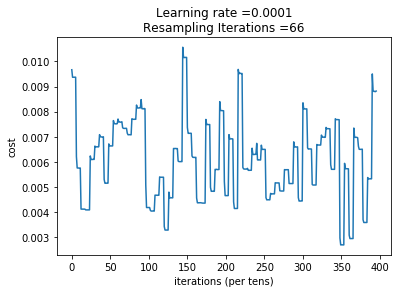

Parameters have been trained!
Saving parameters
pkl saved
Training Session 2
loaded exising dataset
Past parameters updated
Iteration 0


A Jupyter Widget

Cost after epoch 0: 0.009681
Cost after epoch 10: 0.009377
Cost after epoch 20: 0.009383
Training error: 0.005078
Validation error: 0.004238
loaded exising dataset
Iteration 1


A Jupyter Widget

Cost after epoch 0: 0.006147
Cost after epoch 10: 0.005751
Cost after epoch 20: 0.005754
Training error: 0.002812
Validation error: 0.009774
loaded exising dataset
Iteration 2


A Jupyter Widget

Cost after epoch 0: 0.004118
Cost after epoch 10: 0.004115
Cost after epoch 20: 0.004118
Training error: 0.002070
Validation error: 0.009309
loaded exising dataset
Iteration 3


A Jupyter Widget

Cost after epoch 0: 0.004088
Cost after epoch 10: 0.004086
Cost after epoch 20: 0.004083
Training error: 0.002518
Validation error: 0.010377
loaded exising dataset
Iteration 4


A Jupyter Widget

Cost after epoch 0: 0.006266
Cost after epoch 10: 0.006093
Cost after epoch 20: 0.006099
Training error: 0.003014
Validation error: 0.004976
loaded exising dataset
Iteration 5


A Jupyter Widget

Cost after epoch 0: 0.006631
Cost after epoch 10: 0.006596
Cost after epoch 20: 0.006601
Training error: 0.003507
Validation error: 0.004711
loaded exising dataset
Iteration 6


A Jupyter Widget

Cost after epoch 0: 0.007084
Cost after epoch 10: 0.006989
Cost after epoch 20: 0.006988
Training error: 0.004121
Validation error: 0.004617
loaded exising dataset
Iteration 7


A Jupyter Widget

Cost after epoch 0: 0.005295
Cost after epoch 10: 0.005150
Cost after epoch 20: 0.005145
Training error: 0.002598
Validation error: 0.005813
loaded exising dataset
Iteration 8


A Jupyter Widget

Cost after epoch 0: 0.006726
Cost after epoch 10: 0.006628
Cost after epoch 20: 0.006636
Training error: 0.003657
Validation error: 0.004646
loaded exising dataset
Iteration 9


A Jupyter Widget

Cost after epoch 0: 0.007648
Cost after epoch 10: 0.007515
Cost after epoch 20: 0.007520
Training error: 0.005333
Validation error: 0.004185
loaded exising dataset
Iteration 10


A Jupyter Widget

Cost after epoch 0: 0.007707
Cost after epoch 10: 0.007587
Cost after epoch 20: 0.007584
Training error: 0.004229
Validation error: 0.004721
loaded exising dataset
Iteration 11


A Jupyter Widget

Cost after epoch 0: 0.007375
Cost after epoch 10: 0.007328
Cost after epoch 20: 0.007336
Training error: 0.003444
Validation error: 0.004865
loaded exising dataset
Iteration 12


A Jupyter Widget

Cost after epoch 0: 0.007146
Cost after epoch 10: 0.007081
Cost after epoch 20: 0.007084
Training error: 0.003848
Validation error: 0.004649
loaded exising dataset
Iteration 13


A Jupyter Widget

Cost after epoch 0: 0.007716
Cost after epoch 10: 0.007704
Cost after epoch 20: 0.007693
Training error: 0.004230
Validation error: 0.005089
loaded exising dataset
Iteration 14


A Jupyter Widget

Cost after epoch 0: 0.008237
Cost after epoch 10: 0.008150
Cost after epoch 20: 0.008143
Training error: 0.004410
Validation error: 0.004456
loaded exising dataset
Iteration 15


A Jupyter Widget

Cost after epoch 0: 0.008450
Cost after epoch 10: 0.008109
Cost after epoch 20: 0.008122
Training error: 0.006156
Validation error: 0.003559
loaded exising dataset
Iteration 16


A Jupyter Widget

Cost after epoch 0: 0.005085
Cost after epoch 10: 0.004179
Cost after epoch 20: 0.004179
Training error: 0.002741
Validation error: 0.011010
loaded exising dataset
Iteration 17


A Jupyter Widget

Cost after epoch 0: 0.004069
Cost after epoch 10: 0.004038
Cost after epoch 20: 0.004038
Training error: 0.002781
Validation error: 0.005916
loaded exising dataset
Iteration 18


A Jupyter Widget

Cost after epoch 0: 0.004673
Cost after epoch 10: 0.004668
Cost after epoch 20: 0.004669
Training error: 0.002560
Validation error: 0.005582
loaded exising dataset
Iteration 19


A Jupyter Widget

Cost after epoch 0: 0.005399
Cost after epoch 10: 0.005388
Cost after epoch 20: 0.005388
Training error: 0.002713
Validation error: 0.006947
loaded exising dataset
Iteration 20


A Jupyter Widget

Cost after epoch 0: 0.003423
Cost after epoch 10: 0.003283
Cost after epoch 20: 0.003283
Training error: 0.002339
Validation error: 0.027841
loaded exising dataset
Iteration 21


A Jupyter Widget

Cost after epoch 0: 0.004801
Cost after epoch 10: 0.004566
Cost after epoch 20: 0.004567
Training error: 0.002361
Validation error: 0.005738
loaded exising dataset
Iteration 22


A Jupyter Widget

Cost after epoch 0: 0.006533
Cost after epoch 10: 0.006530
Cost after epoch 20: 0.006528
Training error: 0.003300
Validation error: 0.006168
loaded exising dataset
Iteration 23


A Jupyter Widget

Cost after epoch 0: 0.006027
Cost after epoch 10: 0.006008
Cost after epoch 20: 0.006008
Training error: 0.003323
Validation error: 0.005499
loaded exising dataset
Iteration 24


A Jupyter Widget

Cost after epoch 0: 0.010598
Cost after epoch 10: 0.010155
Cost after epoch 20: 0.010163
Training error: 0.004860
Validation error: 0.004068
loaded exising dataset
Iteration 25


A Jupyter Widget

Cost after epoch 0: 0.007369
Cost after epoch 10: 0.007139
Cost after epoch 20: 0.007136
Training error: 0.004334
Validation error: 0.004794
loaded exising dataset
Iteration 26


A Jupyter Widget

Cost after epoch 0: 0.006247
Cost after epoch 10: 0.006170
Cost after epoch 20: 0.006179
Training error: 0.003735
Validation error: 0.004519
loaded exising dataset
Iteration 27


A Jupyter Widget

Cost after epoch 0: 0.004555
Cost after epoch 10: 0.004368
Cost after epoch 20: 0.004372
Training error: 0.003236
Validation error: 0.005683
loaded exising dataset
Iteration 28


A Jupyter Widget

Cost after epoch 0: 0.004363
Cost after epoch 10: 0.004358
Cost after epoch 20: 0.004358
Training error: 0.002800
Validation error: 0.007331
loaded exising dataset
Iteration 29


A Jupyter Widget

Cost after epoch 0: 0.007690
Cost after epoch 10: 0.007486
Cost after epoch 20: 0.007483
Training error: 0.003972
Validation error: 0.004630
loaded exising dataset
Iteration 30


A Jupyter Widget

Cost after epoch 0: 0.004996
Cost after epoch 10: 0.004827
Cost after epoch 20: 0.004827
Training error: 0.003116
Validation error: 0.005673
loaded exising dataset
Iteration 31


A Jupyter Widget

Cost after epoch 0: 0.005706
Cost after epoch 10: 0.005692
Cost after epoch 20: 0.005691
Training error: 0.003110
Validation error: 0.006823
loaded exising dataset
Iteration 32


A Jupyter Widget

Cost after epoch 0: 0.008428
Cost after epoch 10: 0.008045
Cost after epoch 20: 0.008045
Training error: 0.004745
Validation error: 0.003932
loaded exising dataset
Iteration 33


A Jupyter Widget

Cost after epoch 0: 0.005218
Cost after epoch 10: 0.004655
Cost after epoch 20: 0.004653
Training error: 0.002390
Validation error: 0.007767
loaded exising dataset
Iteration 34


A Jupyter Widget

Cost after epoch 0: 0.007093
Cost after epoch 10: 0.006914
Cost after epoch 20: 0.006912
Training error: 0.003649
Validation error: 0.005063
loaded exising dataset
Iteration 35


A Jupyter Widget

Cost after epoch 0: 0.004388
Cost after epoch 10: 0.004143
Cost after epoch 20: 0.004141
Training error: 0.002132
Validation error: 0.010420
loaded exising dataset
Iteration 36


A Jupyter Widget

Cost after epoch 0: 0.009689
Cost after epoch 10: 0.009516
Cost after epoch 20: 0.009530
Training error: 0.004314
Validation error: 0.004632
loaded exising dataset
Iteration 37


A Jupyter Widget

Cost after epoch 0: 0.005783
Cost after epoch 10: 0.005712
Cost after epoch 20: 0.005726
Training error: 0.003326
Validation error: 0.006549
loaded exising dataset
Iteration 38


A Jupyter Widget

Cost after epoch 0: 0.005740
Cost after epoch 10: 0.005664
Cost after epoch 20: 0.005667
Training error: 0.003971
Validation error: 0.004530
loaded exising dataset
Iteration 39


A Jupyter Widget

Cost after epoch 0: 0.006571
Cost after epoch 10: 0.006292
Cost after epoch 20: 0.006292
Training error: 0.003324
Validation error: 0.004504
loaded exising dataset
Iteration 40


A Jupyter Widget

Cost after epoch 0: 0.006745
Cost after epoch 10: 0.006073
Cost after epoch 20: 0.006072
Training error: 0.002766
Validation error: 0.014132
loaded exising dataset
Iteration 41


A Jupyter Widget

Cost after epoch 0: 0.006641
Cost after epoch 10: 0.006494
Cost after epoch 20: 0.006495
Training error: 0.003583
Validation error: 0.005058
loaded exising dataset
Iteration 42


A Jupyter Widget

Cost after epoch 0: 0.004569
Cost after epoch 10: 0.004489
Cost after epoch 20: 0.004490
Training error: 0.002393
Validation error: 0.007749
loaded exising dataset
Iteration 43


A Jupyter Widget

Cost after epoch 0: 0.004745
Cost after epoch 10: 0.004724
Cost after epoch 20: 0.004725
Training error: 0.002999
Validation error: 0.005715
loaded exising dataset
Iteration 44


A Jupyter Widget

Cost after epoch 0: 0.005165
Cost after epoch 10: 0.005164
Cost after epoch 20: 0.005162
Training error: 0.003059
Validation error: 0.006056
loaded exising dataset
Iteration 45


A Jupyter Widget

Cost after epoch 0: 0.004848
Cost after epoch 10: 0.004838
Cost after epoch 20: 0.004838
Training error: 0.002497
Validation error: 0.008066
loaded exising dataset
Iteration 46


A Jupyter Widget

Cost after epoch 0: 0.005689
Cost after epoch 10: 0.005688
Cost after epoch 20: 0.005687
Training error: 0.003210
Validation error: 0.008636
loaded exising dataset
Iteration 47


A Jupyter Widget

Cost after epoch 0: 0.005136
Cost after epoch 10: 0.005134
Cost after epoch 20: 0.005139
Training error: 0.002363
Validation error: 0.009606
loaded exising dataset
Iteration 48


A Jupyter Widget

Cost after epoch 0: 0.006728
Cost after epoch 10: 0.006589
Cost after epoch 20: 0.006590
Training error: 0.004088
Validation error: 0.004706
loaded exising dataset
Iteration 49


A Jupyter Widget

Cost after epoch 0: 0.004575
Cost after epoch 10: 0.004431
Cost after epoch 20: 0.004439
Training error: 0.003721
Validation error: 0.004510
loaded exising dataset
Iteration 50


A Jupyter Widget

Cost after epoch 0: 0.008352
Cost after epoch 10: 0.008111
Cost after epoch 20: 0.008114
Training error: 0.003918
Validation error: 0.004731
loaded exising dataset
Iteration 51


A Jupyter Widget

Cost after epoch 0: 0.006556
Cost after epoch 10: 0.006514
Cost after epoch 20: 0.006513
Training error: 0.003242
Validation error: 0.005304
loaded exising dataset
Iteration 52


A Jupyter Widget

Cost after epoch 0: 0.005094
Cost after epoch 10: 0.005075
Cost after epoch 20: 0.005077
Training error: 0.002479
Validation error: 0.006063
loaded exising dataset
Iteration 53


A Jupyter Widget

Cost after epoch 0: 0.006690
Cost after epoch 10: 0.006670
Cost after epoch 20: 0.006674
Training error: 0.003867
Validation error: 0.005078
loaded exising dataset
Iteration 54


A Jupyter Widget

Cost after epoch 0: 0.007076
Cost after epoch 10: 0.006975
Cost after epoch 20: 0.006984
Training error: 0.004540
Validation error: 0.004349
loaded exising dataset
Iteration 55


A Jupyter Widget

Cost after epoch 0: 0.007375
Cost after epoch 10: 0.007320
Cost after epoch 20: 0.007325
Training error: 0.004112
Validation error: 0.004386
loaded exising dataset
Iteration 56


A Jupyter Widget

Cost after epoch 0: 0.005890
Cost after epoch 10: 0.005703
Cost after epoch 20: 0.005702
Training error: 0.004036
Validation error: 0.005767
loaded exising dataset
Iteration 57


A Jupyter Widget

Cost after epoch 0: 0.007721
Cost after epoch 10: 0.007676
Cost after epoch 20: 0.007684
Training error: 0.004293
Validation error: 0.004814
loaded exising dataset
Iteration 58


A Jupyter Widget

Cost after epoch 0: 0.002963
Cost after epoch 10: 0.002691
Cost after epoch 20: 0.002691
Training error: 0.001897
Validation error: 0.011026
loaded exising dataset
Iteration 59


A Jupyter Widget

Cost after epoch 0: 0.005903
Cost after epoch 10: 0.005728
Cost after epoch 20: 0.005727
Training error: 0.003071
Validation error: 0.004885
loaded exising dataset
Iteration 60


A Jupyter Widget

Cost after epoch 0: 0.003075
Cost after epoch 10: 0.002943
Cost after epoch 20: 0.002943
Training error: 0.002232
Validation error: 0.010301
loaded exising dataset
Iteration 61


A Jupyter Widget

Cost after epoch 0: 0.007332
Cost after epoch 10: 0.006967
Cost after epoch 20: 0.006976
Training error: 0.003287
Validation error: 0.004672
loaded exising dataset
Iteration 62


A Jupyter Widget

Cost after epoch 0: 0.006616
Cost after epoch 10: 0.006504
Cost after epoch 20: 0.006500
Training error: 0.003967
Validation error: 0.004921
loaded exising dataset
Iteration 63


A Jupyter Widget

Cost after epoch 0: 0.003695
Cost after epoch 10: 0.003584
Cost after epoch 20: 0.003584
Training error: 0.002400
Validation error: 0.011366
loaded exising dataset
Iteration 64


A Jupyter Widget

Cost after epoch 0: 0.005364
Cost after epoch 10: 0.005323
Cost after epoch 20: 0.005322
Training error: 0.003037
Validation error: 0.005995
loaded exising dataset
Iteration 65


A Jupyter Widget

Cost after epoch 0: 0.009559
Cost after epoch 10: 0.008799
Cost after epoch 20: 0.008811
Training error: 0.006948
Validation error: 0.003434


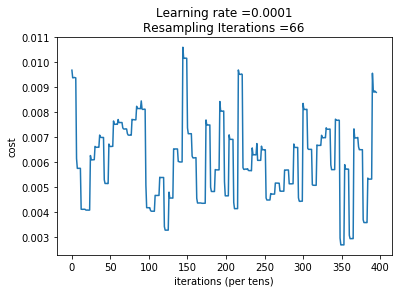

Parameters have been trained!
Saving parameters
pkl saved
Training Session 3
loaded exising dataset
Past parameters updated
Iteration 0


A Jupyter Widget

Cost after epoch 0: 0.009651
Cost after epoch 10: 0.009380
Cost after epoch 20: 0.009378
Training error: 0.005097
Validation error: 0.004285
loaded exising dataset
Iteration 1


A Jupyter Widget

Cost after epoch 0: 0.006153
Cost after epoch 10: 0.005753
Cost after epoch 20: 0.005754
Training error: 0.002796
Validation error: 0.009476
loaded exising dataset
Iteration 2


A Jupyter Widget

Cost after epoch 0: 0.004117
Cost after epoch 10: 0.004115
Cost after epoch 20: 0.004118
Training error: 0.002076
Validation error: 0.009382
loaded exising dataset
Iteration 3


A Jupyter Widget

Cost after epoch 0: 0.004085
Cost after epoch 10: 0.004086
Cost after epoch 20: 0.004083
Training error: 0.002489
Validation error: 0.010067
loaded exising dataset
Iteration 4


A Jupyter Widget

Cost after epoch 0: 0.006250
Cost after epoch 10: 0.006094
Cost after epoch 20: 0.006094
Training error: 0.003026
Validation error: 0.005008
loaded exising dataset
Iteration 5


A Jupyter Widget

Cost after epoch 0: 0.006627
Cost after epoch 10: 0.006601
Cost after epoch 20: 0.006597
Training error: 0.003451
Validation error: 0.004636
loaded exising dataset
Iteration 6


A Jupyter Widget

Cost after epoch 0: 0.007082
Cost after epoch 10: 0.007003
Cost after epoch 20: 0.006996
Training error: 0.004079
Validation error: 0.004545
loaded exising dataset
Iteration 7


A Jupyter Widget

Cost after epoch 0: 0.005292
Cost after epoch 10: 0.005154
Cost after epoch 20: 0.005151
Training error: 0.002468
Validation error: 0.005384
loaded exising dataset
Iteration 8


A Jupyter Widget

Cost after epoch 0: 0.006703
Cost after epoch 10: 0.006634
Cost after epoch 20: 0.006634
Training error: 0.003644
Validation error: 0.004596
loaded exising dataset
Iteration 9


A Jupyter Widget

Cost after epoch 0: 0.007638
Cost after epoch 10: 0.007514
Cost after epoch 20: 0.007517
Training error: 0.005258
Validation error: 0.004107
loaded exising dataset
Iteration 10


A Jupyter Widget

Cost after epoch 0: 0.007706
Cost after epoch 10: 0.007584
Cost after epoch 20: 0.007588
Training error: 0.004307
Validation error: 0.004932
loaded exising dataset
Iteration 11


A Jupyter Widget

Cost after epoch 0: 0.007362
Cost after epoch 10: 0.007345
Cost after epoch 20: 0.007335
Training error: 0.003455
Validation error: 0.004881
loaded exising dataset
Iteration 12


A Jupyter Widget

Cost after epoch 0: 0.007143
Cost after epoch 10: 0.007080
Cost after epoch 20: 0.007085
Training error: 0.003941
Validation error: 0.004821
loaded exising dataset
Iteration 13


A Jupyter Widget

Cost after epoch 0: 0.007718
Cost after epoch 10: 0.007696
Cost after epoch 20: 0.007712
Training error: 0.004187
Validation error: 0.005014
loaded exising dataset
Iteration 14


A Jupyter Widget

Cost after epoch 0: 0.008241
Cost after epoch 10: 0.008151
Cost after epoch 20: 0.008160
Training error: 0.004327
Validation error: 0.004357
loaded exising dataset
Iteration 15


A Jupyter Widget

Cost after epoch 0: 0.008461
Cost after epoch 10: 0.008111
Cost after epoch 20: 0.008111
Training error: 0.006138
Validation error: 0.003548
loaded exising dataset
Iteration 16


A Jupyter Widget

Cost after epoch 0: 0.005090
Cost after epoch 10: 0.004181
Cost after epoch 20: 0.004181
Training error: 0.002735
Validation error: 0.010904
loaded exising dataset
Iteration 17


A Jupyter Widget

Cost after epoch 0: 0.004070
Cost after epoch 10: 0.004038
Cost after epoch 20: 0.004039
Training error: 0.002752
Validation error: 0.005751
loaded exising dataset
Iteration 18


A Jupyter Widget

Cost after epoch 0: 0.004673
Cost after epoch 10: 0.004670
Cost after epoch 20: 0.004669
Training error: 0.002568
Validation error: 0.005757
loaded exising dataset
Iteration 19


A Jupyter Widget

Cost after epoch 0: 0.005394
Cost after epoch 10: 0.005387
Cost after epoch 20: 0.005388
Training error: 0.002697
Validation error: 0.006805
loaded exising dataset
Iteration 20


A Jupyter Widget

Cost after epoch 0: 0.003424
Cost after epoch 10: 0.003283
Cost after epoch 20: 0.003283
Training error: 0.002317
Validation error: 0.027131
loaded exising dataset
Iteration 21


A Jupyter Widget

Cost after epoch 0: 0.004799
Cost after epoch 10: 0.004566
Cost after epoch 20: 0.004564
Training error: 0.002358
Validation error: 0.005766
loaded exising dataset
Iteration 22


A Jupyter Widget

Cost after epoch 0: 0.006533
Cost after epoch 10: 0.006529
Cost after epoch 20: 0.006528
Training error: 0.003263
Validation error: 0.005953
loaded exising dataset
Iteration 23


A Jupyter Widget

Cost after epoch 0: 0.006023
Cost after epoch 10: 0.006007
Cost after epoch 20: 0.006012
Training error: 0.003322
Validation error: 0.005526
loaded exising dataset
Iteration 24


A Jupyter Widget

Cost after epoch 0: 0.010568
Cost after epoch 10: 0.010159
Cost after epoch 20: 0.010158
Training error: 0.004893
Validation error: 0.004108
loaded exising dataset
Iteration 25


A Jupyter Widget

Cost after epoch 0: 0.007364
Cost after epoch 10: 0.007132
Cost after epoch 20: 0.007139
Training error: 0.004364
Validation error: 0.004895
loaded exising dataset
Iteration 26


A Jupyter Widget

Cost after epoch 0: 0.006226
Cost after epoch 10: 0.006182
Cost after epoch 20: 0.006176
Training error: 0.003820
Validation error: 0.004470
loaded exising dataset
Iteration 27


A Jupyter Widget

Cost after epoch 0: 0.004555
Cost after epoch 10: 0.004372
Cost after epoch 20: 0.004368
Training error: 0.003233
Validation error: 0.005610
loaded exising dataset
Iteration 28


A Jupyter Widget

Cost after epoch 0: 0.004367
Cost after epoch 10: 0.004358
Cost after epoch 20: 0.004354
Training error: 0.002788
Validation error: 0.007015
loaded exising dataset
Iteration 29


A Jupyter Widget

Cost after epoch 0: 0.007673
Cost after epoch 10: 0.007487
Cost after epoch 20: 0.007479
Training error: 0.003901
Validation error: 0.004513
loaded exising dataset
Iteration 30


A Jupyter Widget

Cost after epoch 0: 0.004984
Cost after epoch 10: 0.004827
Cost after epoch 20: 0.004828
Training error: 0.003149
Validation error: 0.005821
loaded exising dataset
Iteration 31


A Jupyter Widget

Cost after epoch 0: 0.005703
Cost after epoch 10: 0.005695
Cost after epoch 20: 0.005694
Training error: 0.003083
Validation error: 0.006802
loaded exising dataset
Iteration 32


A Jupyter Widget

Cost after epoch 0: 0.008395
Cost after epoch 10: 0.008048
Cost after epoch 20: 0.008040
Training error: 0.004711
Validation error: 0.003903
loaded exising dataset
Iteration 33


A Jupyter Widget

Cost after epoch 0: 0.005223
Cost after epoch 10: 0.004656
Cost after epoch 20: 0.004654
Training error: 0.002432
Validation error: 0.008068
loaded exising dataset
Iteration 34


A Jupyter Widget

Cost after epoch 0: 0.007095
Cost after epoch 10: 0.006909
Cost after epoch 20: 0.006913
Training error: 0.003635
Validation error: 0.005007
loaded exising dataset
Iteration 35


A Jupyter Widget

Cost after epoch 0: 0.004403
Cost after epoch 10: 0.004142
Cost after epoch 20: 0.004141
Training error: 0.002087
Validation error: 0.009824
loaded exising dataset
Iteration 36


A Jupyter Widget

Cost after epoch 0: 0.009673
Cost after epoch 10: 0.009510
Cost after epoch 20: 0.009515
Training error: 0.004321
Validation error: 0.004652
loaded exising dataset
Iteration 37


A Jupyter Widget

Cost after epoch 0: 0.005787
Cost after epoch 10: 0.005711
Cost after epoch 20: 0.005713
Training error: 0.003335
Validation error: 0.006600
loaded exising dataset
Iteration 38


A Jupyter Widget

Cost after epoch 0: 0.005743
Cost after epoch 10: 0.005667
Cost after epoch 20: 0.005662
Training error: 0.004002
Validation error: 0.004561
loaded exising dataset
Iteration 39


A Jupyter Widget

Cost after epoch 0: 0.006545
Cost after epoch 10: 0.006297
Cost after epoch 20: 0.006299
Training error: 0.003354
Validation error: 0.004574
loaded exising dataset
Iteration 40


A Jupyter Widget

Cost after epoch 0: 0.006745
Cost after epoch 10: 0.006078
Cost after epoch 20: 0.006074
Training error: 0.002770
Validation error: 0.014924
loaded exising dataset
Iteration 41


A Jupyter Widget

Cost after epoch 0: 0.006664
Cost after epoch 10: 0.006495
Cost after epoch 20: 0.006500
Training error: 0.003566
Validation error: 0.004994
loaded exising dataset
Iteration 42


A Jupyter Widget

Cost after epoch 0: 0.004577
Cost after epoch 10: 0.004488
Cost after epoch 20: 0.004489
Training error: 0.002429
Validation error: 0.007965
loaded exising dataset
Iteration 43


A Jupyter Widget

Cost after epoch 0: 0.004747
Cost after epoch 10: 0.004723
Cost after epoch 20: 0.004725
Training error: 0.003007
Validation error: 0.005793
loaded exising dataset
Iteration 44


A Jupyter Widget

Cost after epoch 0: 0.005163
Cost after epoch 10: 0.005164
Cost after epoch 20: 0.005163
Training error: 0.003094
Validation error: 0.006123
loaded exising dataset
Iteration 45


A Jupyter Widget

Cost after epoch 0: 0.004845
Cost after epoch 10: 0.004844
Cost after epoch 20: 0.004842
Training error: 0.002408
Validation error: 0.007489
loaded exising dataset
Iteration 46


A Jupyter Widget

Cost after epoch 0: 0.005691
Cost after epoch 10: 0.005687
Cost after epoch 20: 0.005687
Training error: 0.003202
Validation error: 0.008269
loaded exising dataset
Iteration 47


A Jupyter Widget

Cost after epoch 0: 0.005136
Cost after epoch 10: 0.005135
Cost after epoch 20: 0.005135
Training error: 0.002312
Validation error: 0.008991
loaded exising dataset
Iteration 48


A Jupyter Widget

Cost after epoch 0: 0.006728
Cost after epoch 10: 0.006587
Cost after epoch 20: 0.006589
Training error: 0.004043
Validation error: 0.004635
loaded exising dataset
Iteration 49


A Jupyter Widget

Cost after epoch 0: 0.004586
Cost after epoch 10: 0.004441
Cost after epoch 20: 0.004443
Training error: 0.003658
Validation error: 0.004448
loaded exising dataset
Iteration 50


A Jupyter Widget

Cost after epoch 0: 0.008350
Cost after epoch 10: 0.008107
Cost after epoch 20: 0.008108
Training error: 0.003913
Validation error: 0.004725
loaded exising dataset
Iteration 51


A Jupyter Widget

Cost after epoch 0: 0.006557
Cost after epoch 10: 0.006514
Cost after epoch 20: 0.006510
Training error: 0.003267
Validation error: 0.005455
loaded exising dataset
Iteration 52


A Jupyter Widget

Cost after epoch 0: 0.005096
Cost after epoch 10: 0.005077
Cost after epoch 20: 0.005073
Training error: 0.002448
Validation error: 0.005867
loaded exising dataset
Iteration 53


A Jupyter Widget

Cost after epoch 0: 0.006688
Cost after epoch 10: 0.006674
Cost after epoch 20: 0.006670
Training error: 0.003899
Validation error: 0.005188
loaded exising dataset
Iteration 54


A Jupyter Widget

Cost after epoch 0: 0.007081
Cost after epoch 10: 0.006983
Cost after epoch 20: 0.006979
Training error: 0.004596
Validation error: 0.004416
loaded exising dataset
Iteration 55


A Jupyter Widget

Cost after epoch 0: 0.007380
Cost after epoch 10: 0.007315
Cost after epoch 20: 0.007322
Training error: 0.004090
Validation error: 0.004435
loaded exising dataset
Iteration 56


A Jupyter Widget

Cost after epoch 0: 0.005893
Cost after epoch 10: 0.005699
Cost after epoch 20: 0.005701
Training error: 0.003953
Validation error: 0.005493
loaded exising dataset
Iteration 57


A Jupyter Widget

Cost after epoch 0: 0.007714
Cost after epoch 10: 0.007689
Cost after epoch 20: 0.007678
Training error: 0.004279
Validation error: 0.004815
loaded exising dataset
Iteration 58


A Jupyter Widget

Cost after epoch 0: 0.002965
Cost after epoch 10: 0.002691
Cost after epoch 20: 0.002693
Training error: 0.001910
Validation error: 0.011168
loaded exising dataset
Iteration 59


A Jupyter Widget

Cost after epoch 0: 0.005901
Cost after epoch 10: 0.005720
Cost after epoch 20: 0.005717
Training error: 0.003174
Validation error: 0.005116
loaded exising dataset
Iteration 60


A Jupyter Widget

Cost after epoch 0: 0.003074
Cost after epoch 10: 0.002943
Cost after epoch 20: 0.002944
Training error: 0.002251
Validation error: 0.010489
loaded exising dataset
Iteration 61


A Jupyter Widget

Cost after epoch 0: 0.007369
Cost after epoch 10: 0.006981
Cost after epoch 20: 0.006984
Training error: 0.003278
Validation error: 0.004809
loaded exising dataset
Iteration 62


A Jupyter Widget

Cost after epoch 0: 0.006612
Cost after epoch 10: 0.006500
Cost after epoch 20: 0.006500
Training error: 0.003996
Validation error: 0.005041
loaded exising dataset
Iteration 63


A Jupyter Widget

Cost after epoch 0: 0.003681
Cost after epoch 10: 0.003586
Cost after epoch 20: 0.003585
Training error: 0.002425
Validation error: 0.011454
loaded exising dataset
Iteration 64


A Jupyter Widget

Cost after epoch 0: 0.005369
Cost after epoch 10: 0.005323
Cost after epoch 20: 0.005324
Training error: 0.002987
Validation error: 0.005799
loaded exising dataset
Iteration 65


A Jupyter Widget

Cost after epoch 0: 0.009498
Cost after epoch 10: 0.008793
Cost after epoch 20: 0.008805
Training error: 0.006969
Validation error: 0.003435


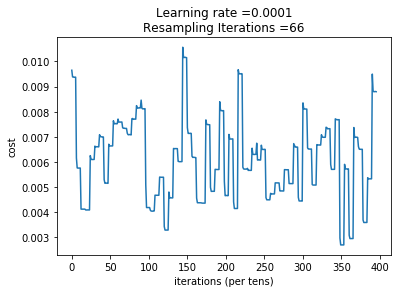

Parameters have been trained!
Saving parameters
pkl saved


In [47]:
try:
    parameters,train_acc,dev_acc,train,k  = pickle.load(open("training_parameters.pkl",'rb'))
    open("training_parameters.pkl",'rb').close()
    print("Parameters loaded")
except:
    print("error")

    
## Training for 3 times (editable )
for i in range(1,4):
    ## Get the full training set back with the same seed
    new_train,_ = train_test_split(df.T, test_size=0.01, random_state=42)
    train = new_train.T
    ## Retrain the model
    k = 0
    
    print("Training Session",i)
    parameters,train_acc,dev_acc,train,k = model(train,dev_X,dev_Y,iterations= 66,
                                                        parameters = parameters,k=k,
                                                        train_acc=train_acc,dev_acc=dev_acc)


### 2. Plotting Results
The below graph shows the mean sqaure error on development set and training set vs number of iterations of training & sampling.<br>
Note the the error on development set may fluctuate rapidly due to the random sampling of training set.<br>
This fluctuate will/should decrease as the number of iterations increases.

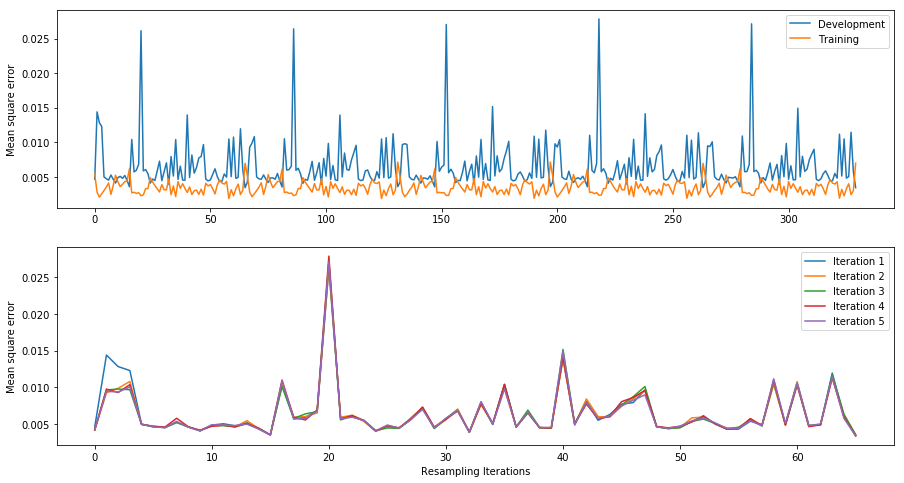

In [56]:
## Plot iteration against mean square error
plt.figure(figsize = (15,8))
plt.subplot(2, 1, 1)
plt.plot(dev_acc)
plt.plot(train_acc)
plt.ylabel('Mean square error')
plt.legend(["Development","Training"])

## Plot iteration against mean square error for each loop through the entire training set
## This shows the repeated training granting limited improvement
plt.subplot(2, 1, 2)
legend = []
for i in range(len(dev_acc)//66):
    plt.plot(dev_acc[66*i:66*(i+1)])
    legend.append("Iteration "+str(i+1) )
plt.xlabel('Resampling Iterations')
plt.ylabel('Mean square error')
plt.legend(legend)
plt.show()